In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
import random
from tqdm import tqdm

In [2]:
# class Layer(object):
#     def __init__(self, l: int, M_max: int):
#         self.l: int = l
#         self.M_max: int = M_max
#         self.points: list[tuple[float, float]] = [tuple[float, float]]

In [3]:
class HNSW(object):
    def __init__(self, M_max: int, M_max0: int):
        self.L: int = 0
        self.M_max: int = M_max
        self.M_max0: int = M_max0
        self.layers: dict[int: list[tuple[float, float]]] = {0: []}
        self.edges: dict[int: list[tuple[tuple[float, float], tuple[float, float]]]] = {0: []}
        self.ep = (0, 0)
        
    def insert_connection(self, l_c: int, p1: tuple[float, float], p2: tuple[float, float]):
        assert 0 <= l_c <= self.L
        self.edges[l_c].append((p1, p2))
        self.edges[l_c].append((p2, p1))
        
    def visualize_hnsw_with_edges(self):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Iterate over each layer and plot points at different z levels
        for layer_idx in range(0, self.L + 1):
            layer = self.layers[layer_idx]
            
            z = layer_idx  # Set the z-axis value for this layer
            # Plot a plane to represent each layer
            x_vals = np.linspace(-3, 3, 10)
            y_vals = np.linspace(-3, 3, 10)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = np.full_like(X, z)
            ax.plot_surface(X, Y, Z, color='gray', alpha=0.1, rstride=100, cstride=100)
            
            # Add text annotation for the layer
            # ax.text(3, 3, z, f"Layer {layer_idx}", color='blue', fontsize=12, ha='center')
            
            # Plot the points for the layer
            for point in layer:
                x, y = point[0], point[1]
                ax.scatter(x, y, z, color='black', s=10)
                
                for lower_z in range(z):
                    ax.plot([x, x], [y, y], [z, lower_z], 'k--', linewidth=0.5)
                
            # Draw edges for this layer as connections between specified points
            for edge in self.edges[layer_idx]:
                start, end = edge
                
                x_vals = [start[0], end[0]]
                y_vals = [start[1], end[1]]
                
                z_vals = [z, z]
                ax.plot(x_vals, y_vals, z_vals, '-', color='gray', linewidth=1)  # Red solid line for edges within the same layer

        ax.scatter(self.ep[0], self.ep[1], self.L, color='blue', s=20)
        
        # Label the axes
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Layer (Z axis)')
        ax.set_title("3D Visualization of HNSW Layers with Internal Edges")
        
        plt.show()
        
    def visualize_hnsw_with_path(self, path, q):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        # Iterate over each layer and plot points at different z levels
        for layer_idx in range(0, self.L + 1):
            layer = self.layers[layer_idx]
            
            z = layer_idx  # Set the z-axis value for this layer
            # Plot a plane to represent each layer
            x_vals = np.linspace(-5, 5, 10)
            y_vals = np.linspace(-5, 5, 10)
            X, Y = np.meshgrid(x_vals, y_vals)
            Z = np.full_like(X, z)
            ax.plot_surface(X, Y, Z, color='gray', alpha=0.1, rstride=100, cstride=100)
            
            # Plot the points for the layer
            for point in layer:
                x, y = point[0], point[1]
                ax.scatter(x, y, z, color='black', s=10)
                
            # Draw edges for this layer as connections between specified points
            for edge in self.edges.get(layer_idx, []):
                start, end = edge
                x_vals = [start[0], end[0]]
                y_vals = [start[1], end[1]]
                z_vals = [z, z]
                ax.plot(x_vals, y_vals, z_vals, '-', color='gray', linewidth=1)
        
        # Plot the path in red
        for layer_idx, points in path.items():
            z = layer_idx  # Set the z-axis value for this layer
            for i in range(len(points) - 1):
                start, end = points[i], points[i + 1]
                x_vals = [start[0], end[0]]
                y_vals = [start[1], end[1]]

                z_vals = [z, z]
                ax.plot(x_vals, y_vals, z_vals, 'r-', linewidth=2)  # Red line for the path
                ax.scatter(start[0], start[1], z, color='red', s=20)  # Red points for the path
            # Ensure the last point is also marked
            if points:
                ax.scatter(points[-1][0], points[-1][1], z, color='red', s=20)

        ax.scatter(self.ep[0], self.ep[1], self.L, color='blue', s=20)
        ax.scatter(q[0], q[1], 0, color='lime', s=40)
        ax.plot([q[0], q[0]], [q[1], q[1]], [0, self.L], '-', color='lime', linewidth=5)
        
        # Label the axes
        ax.set_xlabel('X axis')
        ax.set_ylabel('Y axis')
        ax.set_zlabel('Layer (Z axis)')
        ax.set_title("3D Visualization of HNSW Layers with Path")
        
        plt.show()

In [4]:
def dist(p1: tuple[float, float], p2: tuple[float, float], verbose=False) -> float:
    if verbose: print(f"dist: {p1} - {p2}")
    return math.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

In [5]:
def neighbourhood(hnsw: HNSW, l_c: int, e: tuple[float, float], verbose=False) -> list[tuple[float, float]]:
    if verbose:
        print("===== neighbourhood() =====")
        print(f"l_c: {l_c}, e: {e}")
    
    neighbors: list[tuple[float, float]] = []
    
    if verbose:
        print(hnsw.edges[l_c])
    
    for edge in hnsw.edges[l_c]:
        if edge[0] == e:
            neighbors.append(edge[1])
          
    if verbose:  
        print("final neighbors")
        print(neighbors)
        
        print("="*10)
    return neighbors

In [6]:
def search_layer(hnsw, q: tuple[float, float], ep: list[tuple[float, float]], ef: int, l_c: int, return_path=False, verbose=False):
    if verbose: print("===== search layer() =====")
    v = [x for x in ep] # set of visited elements
    C = [x for x in ep] # set of candidates
    W = [x for x in ep] # dynamic list of found nearest neighbors
    
    paths = []
    
    if verbose: print(v, C, W)
    
    iter_count = 0
    
    while len(C) > 0:
        if verbose: print(f"{iter_count}th iteration")
        iter_count += 1
        
        if verbose: 
            print("C")
            print(C)
            print("="*5)
        
        C.sort(key=lambda point: dist(q, point))
        f = C[-1]
        c = C.pop(0)
        
        paths.append(c)
        
        if dist(c, q) > dist(f, q):
            break # all elements in W are evaluated
        
        neighbors = neighbourhood(hnsw=hnsw, l_c=l_c, e=c)
        
        if verbose: 
            print("neighbors")
            print(neighbors)
        
        for e in neighbors:
            if e not in v:
                v.append(e)
                W.sort(key=lambda point: dist(q, point))
                f = W[-1] # get furthest element from W to q
                
                if dist(e, q) < dist(f, q) or len(W) < ef:
                    if verbose: print(f"append e ({e}) -> C, W")
                    C.append(e)
                    W.append(e)
                    
                    # paths.append(e)
                    
                    if verbose: 
                        print("C, W:")
                        print(C)
                        print(W)
                    
                    if len(W) > ef:
                        W.sort(key=lambda point: dist(q, point))
                        W.pop()
            
    if verbose: print("="*10)     
    
    if return_path:       
        return W, paths
    else:
        return W

In [7]:
def select_neighbors_simple(q, C, M):
    assert len(C) > 0
    
    return [min(C, key=lambda point: dist(q, point))]

In [8]:
def select_neighbors_heuristic(hnsw: HNSW, q, C, M, l_c, extendCandidates: bool=False, keepPrunedConnections: bool=False):
    R = []
    W = [c for c in C]
    
    if extendCandidates:
        for e in C:
            neighbors = neighbourhood(hnsw=hnsw, l_c=l_c, e=e)
            
            for e_adj in neighbors:
                if e_adj not in W:
                    W.append(e_adj)
    
    W_d = []
    
    while len(W) > 0 and len(R) < M:
        W.sort(key=lambda point: dist(q, point))
        e = W.pop(0) # extract nearest element from W to q
        
        # if e is closer to q compared to any element from R
        flag = True
        
        for r in R:
            d_R = dist(r, e)
            d_q = dist(q, e)
            
            if d_q < d_R:
                pass
            else:
                flag = False
                break
        
        if flag:
            R.append(e)
        else:
            W_d.append(e)
    
    if keepPrunedConnections:
        W_d.sort(key=lambda point: dist(q, point))
        while len(W_d) > 0 and len(R) < M:
            e = W_d.pop(0)
            R.append(e)
    
    return R

In [9]:
def insert(hnsw, q, M, M_max, efConstruction, m_L:float=1.0, verbose=False):
    W = []
    ep = [hnsw.ep]
    L = hnsw.L
    
    l = math.floor(-math.log(random.random()) * m_L)
    
    if verbose: print(f"l: {l}, L: {hnsw.L}")
    
    if l > L:
        for i in range(0, l + 1):
            if i not in hnsw.layers.keys():
                hnsw.layers[i] = []
            if i not in hnsw.edges.keys():
                hnsw.edges[i] = []
            
        hnsw.L = l
        L = l
        
        if verbose: print(f"new L: {hnsw.L}, layers: {hnsw.layers}, edges: {hnsw.edges}")
    
    for l_c in range(L, l, -1):
        W = search_layer(hnsw=hnsw, q=q, ep=ep, ef=1,l_c=l_c)
        
        if len(W) > 0:
            ep = [min(W, key=lambda point: dist(q, point))]
        
    for l_c in range(min(L, l), -1, -1):
        W = search_layer(hnsw=hnsw, q=q, ep=ep, ef=efConstruction, l_c=l_c)
        neighbors = select_neighbors_heuristic(hnsw, q, W, M, l_c, True, True)
        
        hnsw.layers[l_c].append(q)
        
        # add bidirectional connections from neighbors to q at layer l_c
        for neighbor in neighbors:
            hnsw.insert_connection(l_c=l_c, p1=q, p2=neighbor)
            hnsw.layers[l_c].append(neighbor)
            if verbose: print(f"insert connection: {q} <-> {neighbor}")
        
        # shrink connections if needed
        for e in neighbors:
            eConn = neighbourhood(hnsw=hnsw, l_c=l_c, e=e)
            
            if len(eConn) > M_max: # shrink connections of e
                # if l_c = 0 then M_max = M_max0
                eNewConn = select_neighbors_heuristic(hnsw, e, eConn, M_max, l_c, True, True)
                
                # replace edges
                # for edge in hnsw.edges[l_c]:
                #     if edge[0] == e:
                        
                
        ep = W
        
    if l > L:
        hnsw.ep = q
    
    if verbose: print(f"ef: {hnsw.ep}")

In [10]:
hnsw = HNSW(M_max=5, M_max0=5)

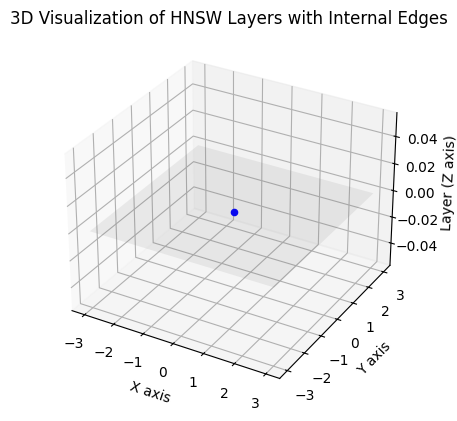

In [11]:
hnsw.visualize_hnsw_with_edges()

In [12]:
insert(hnsw=hnsw, q=(0.51, -0.48), M=2, M_max=5, efConstruction=3, m_L=3)

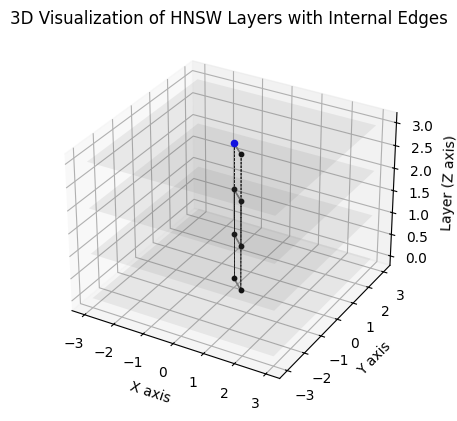

In [13]:
hnsw.visualize_hnsw_with_edges()

In [14]:
insert(hnsw=hnsw, q=(1.13, 0.19), M=2, M_max=5, efConstruction=3, m_L=3)

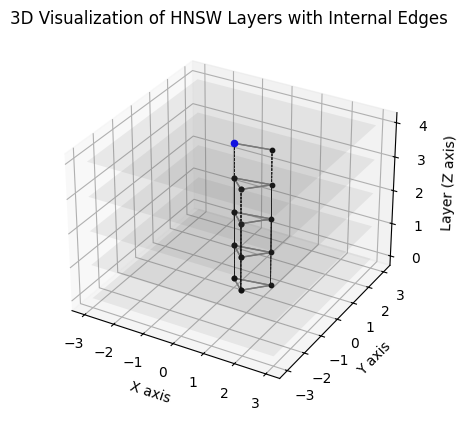

In [15]:
hnsw.visualize_hnsw_with_edges()

In [16]:
x = random.randrange(-500, 500) / 100.0
y = random.randrange(-500, 500) / 100.0
print(x, y)

insert(hnsw, q=(x, y), M=2, M_max=5, efConstruction=3, m_L=3)

1.47 3.04


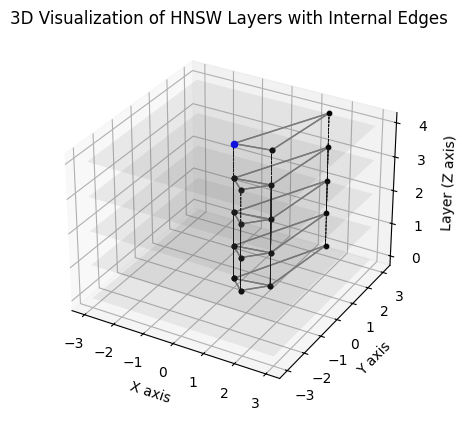

In [17]:
hnsw.visualize_hnsw_with_edges()

100%|██████████| 100/100 [00:00<00:00, 2816.35it/s]


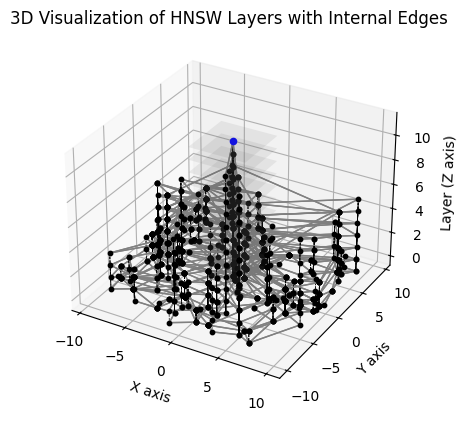

In [18]:
k = 10

for i in tqdm(range(100)):
    x = random.randrange(-k * 100, k * 100) / 100.0
    y = random.randrange(-k * 100, k * 100) / 100.0
    # print(x, y)

    insert(hnsw, q=(x, y), M=2, M_max=5, efConstruction=3, m_L=3)
    
hnsw.visualize_hnsw_with_edges()

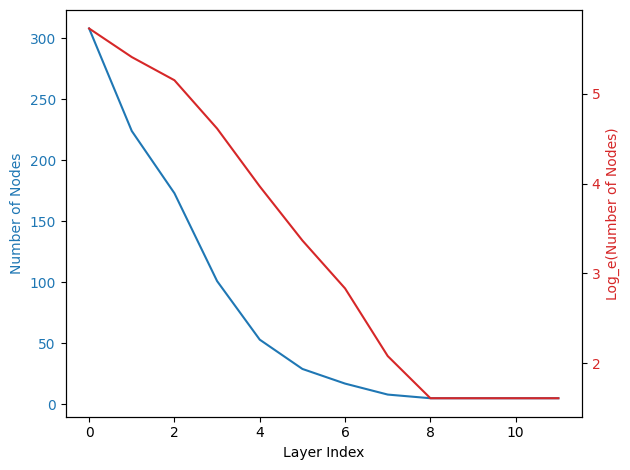

In [19]:
layer_lengths = [len(hnsw.layers[layer_idx]) for layer_idx in hnsw.layers.keys()]

fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Layer Index')
ax1.set_ylabel('Number of Nodes', color=color)
ax1.plot(range(len(layer_lengths)), layer_lengths, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Log_e(Number of Nodes)', color=color)
ax2.plot(range(len(layer_lengths)), np.log(layer_lengths), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

In [20]:
def knn_search(hnsw: HNSW, q: tuple[float, float], K: int, efSearch: int):
    W = []
    ep = hnsw.ep
    L = hnsw.L
    
    paths = {L: [ep]}
    
    for i in range(L - 1, -1, -1):
        paths[i] = []
    
    for l_c in range(L, 0, -1):
        W, p = search_layer(hnsw=hnsw, q=q, ep=[ep], ef=1, l_c=l_c, return_path=True)
        W.sort(key=lambda point: dist(q, point))
        ep = W[0]
        paths[l_c] += p
        paths[l_c].append(ep)
        
    # layer 0
    W, p = search_layer(hnsw=hnsw, q=q, ep=[ep], ef=efSearch, l_c=0, return_path=True)
    W.sort(key=lambda point: dist(q, point))
    
    paths[0] += p
    
    # return top-K
    return W[:K], paths

In [21]:
q = (-2, -4)
results, paths = knn_search(hnsw=hnsw, q=q, K=5, efSearch=10)

In [22]:
for result in results:
    print(f"{result}, dist: {dist(q, result)}")

(-2.1, -5.44), dist: 1.443468046061291
(-3.53, -4.7), dist: 1.6825278600962303
(-0.83, -2.73), dist: 1.7267889274604467
(-1.01, -6.61), dist: 2.7914512354687484
(-3.2, -6.53), dist: 2.8001607096736434


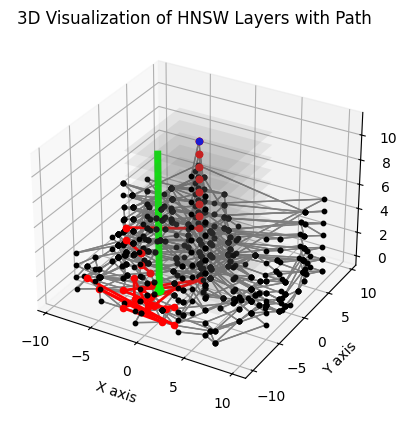

In [23]:
hnsw.visualize_hnsw_with_path(path=paths, q=q)